https://www.kaggle.com/mineshjethva/explore-feature-engineering-xgb-lasso-nn

In [155]:
import numpy as np                      # for matrix calculations
import pandas as pd                     # for easy data frame manipulation
import matplotlib.pyplot as plt         # for plotting data
# to show plot inside python notebook
%matplotlib inline                      
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns                   # for beautiful plots
from scipy import stats                 # to calculate mode, skew and ANOVA, etc.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics

# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [88]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [163]:
train = pd.read_csv('../house price/train.csv')
test = pd.read_csv('../house price/test.csv')

In [164]:
Id = test.Id
target = train.SalePrice

## 欠損値

In [8]:
miss = train.isnull().sum() / len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True, ascending=False)
miss

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

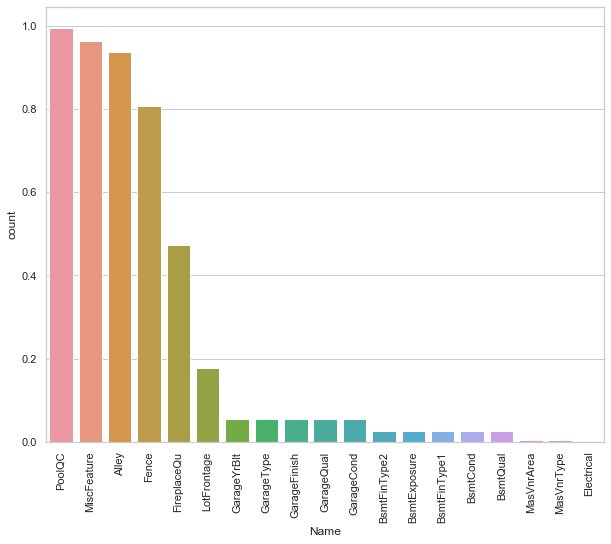

In [9]:
#visualising missing values
miss = miss.to_frame()
miss.columns = ['count']
miss.index.names = ['Name']
miss['Name'] = miss.index

#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'count', data=miss)
plt.xticks(rotation = 90)
plt.show()

## EDA

Skewness is 0.12133506220520406


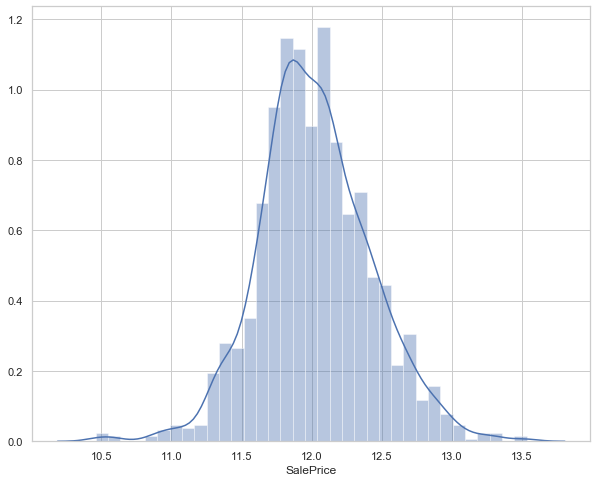

In [11]:
target = np.log(train['SalePrice'])
print ('Skewness is', target.skew())
sns.distplot(target)

In [12]:
numeric_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 38 numeric and 43 categorical columns in train data


In [13]:
del numeric_data['Id']

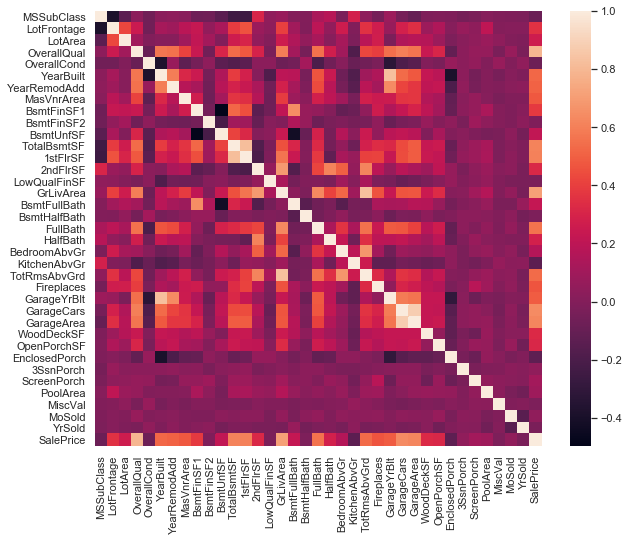

In [17]:
corr = numeric_data.corr()
sns.heatmap(corr)

<Figure size 720x360 with 0 Axes>

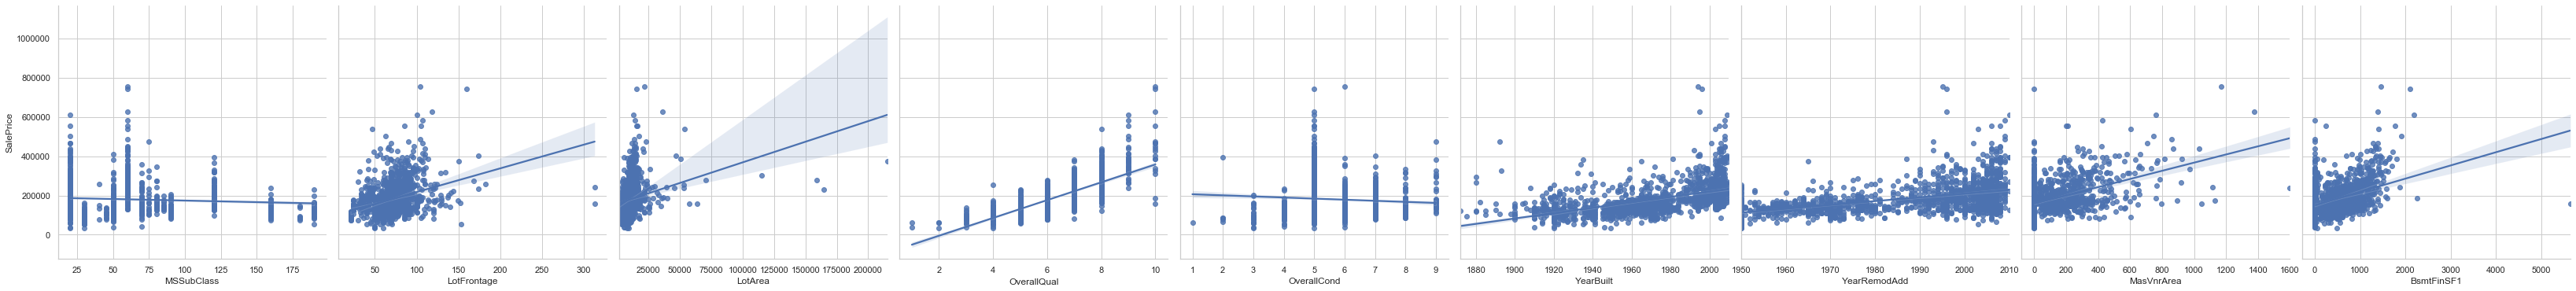

In [26]:
plt.figure(figsize=(10,5))
sns.pairplot(numeric_data.fillna(numeric_data.median())
             ,x_vars=numeric_data.columns[:9]
             , y_vars=numeric_data.columns[-1]
             ,height=5, kind="reg")

In [27]:
print (corr['SalePrice'].sort_values(ascending=False)[:15], '\n') #top 15 values
print ('----------------------')
print (corr['SalePrice'].sort_values(ascending=False)[-5:]) 

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64 

----------------------
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [28]:
pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


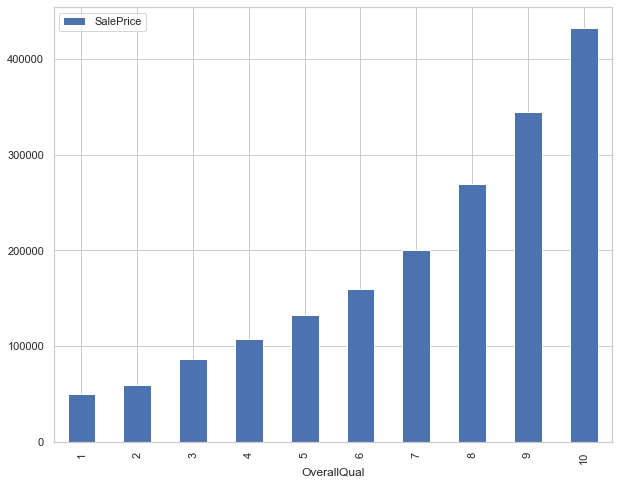

In [29]:
pivot.plot(kind='bar')

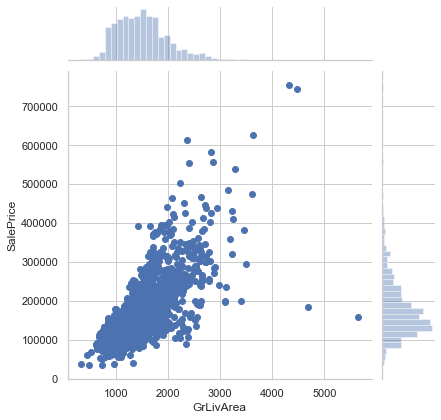

In [30]:
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'])

In [31]:
cat_data.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [32]:
sp_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
sp_pivot

,SalePrice
SaleCondition,
Abnorml,130000
AdjLand,104000
Alloca,148145
Family,140500
Normal,160000
Partial,244600


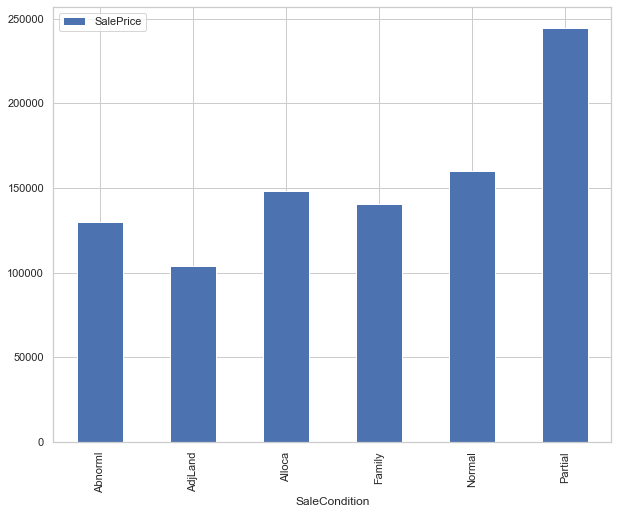

In [34]:
sp_pivot.plot(kind='bar')

C:\Users\user\Anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\user\Anaconda\lib\site-packages\scipy\stats\stats.py:3339: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / len(a)


<module 'matplotlib.pyplot' from 'C:\\Users\\user\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

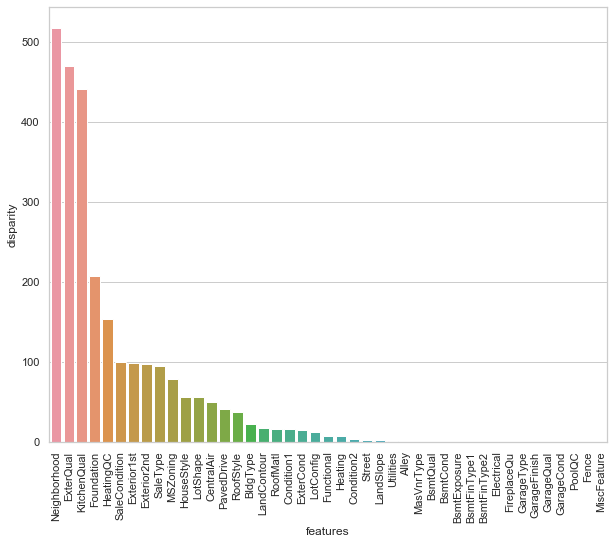

In [36]:
cat = [f for f in train.columns if train.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
           samples = []
           for cls in frame[c].unique():
                  s = frame[frame[c] == cls]['SalePrice'].values
                  samples.append(s)
           pval = stats.f_oneway(*samples)[1]
           pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_data['SalePrice'] = train.SalePrice.values
k = anova(cat_data) 
k['disparity'] = np.log(1./k['pval'].values) 
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 

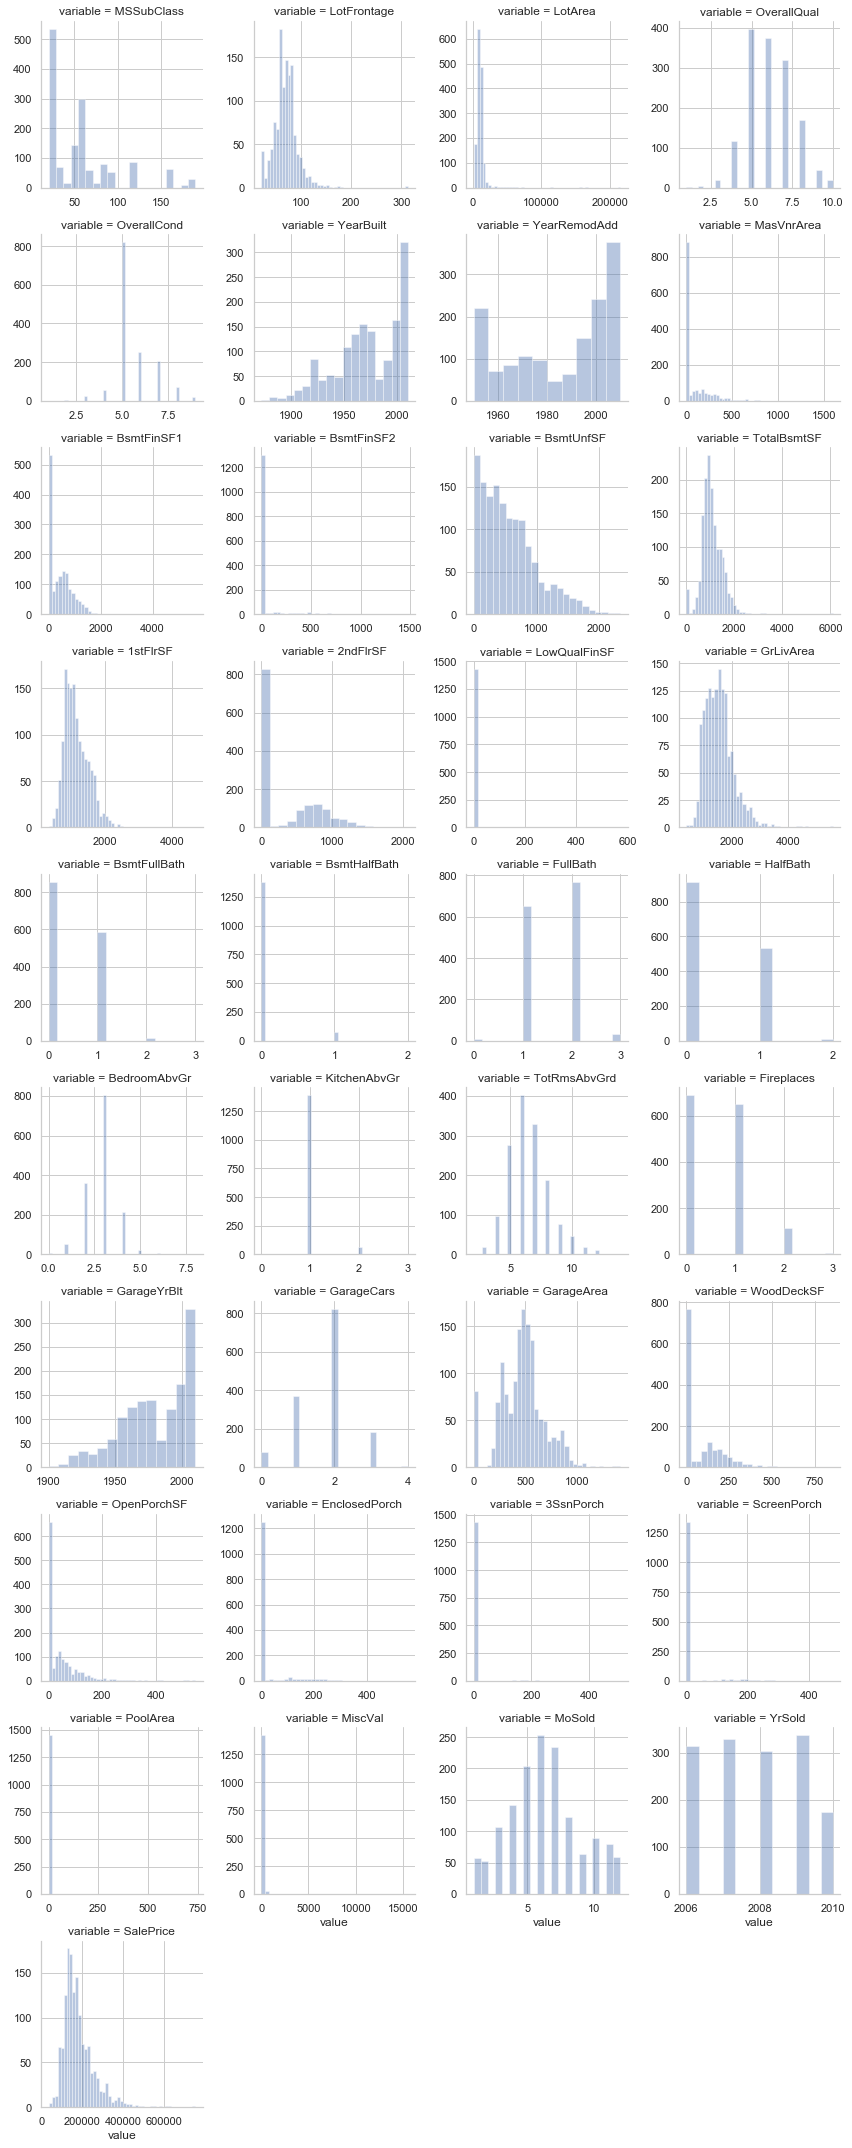

In [46]:
num = [f for f in train.columns if train.dtypes[f] != 'object']
num.remove('Id')
nd = pd.melt(train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value', kde=False)
n1

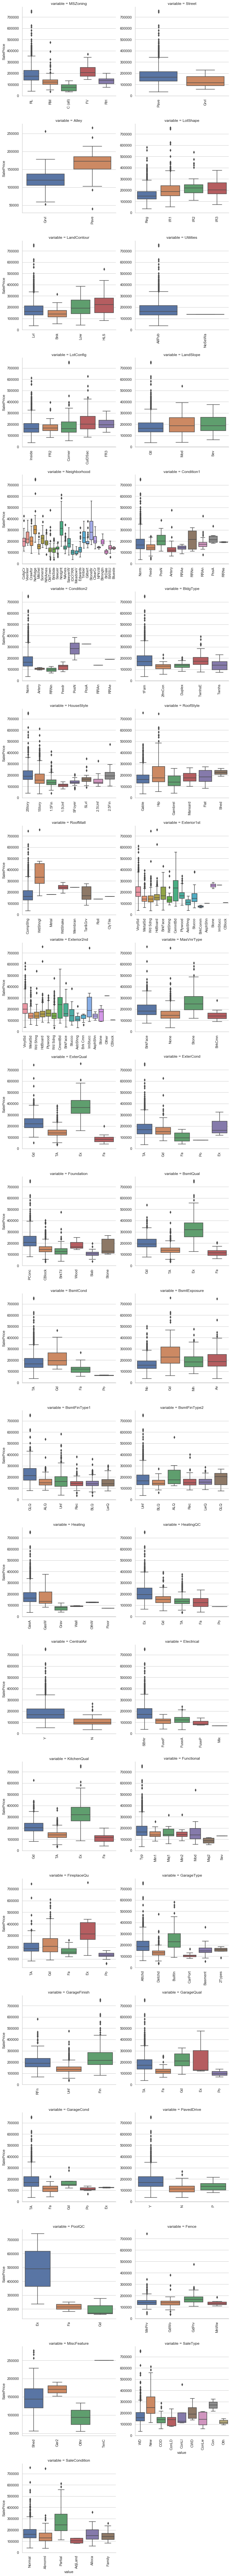

In [49]:
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

cat = [f for f in train.columns if train.dtypes[f] == 'object']

p = pd.melt(train, id_vars='SalePrice', value_vars=cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot, 'value','SalePrice')
g

## 前処理(前回とほぼ同様)

In [50]:
train.drop(train[train['GrLivArea'] > 4000].index, inplace=True)
train.shape

(1456, 81)

In [52]:
test.loc[666, 'GarageQual'] = "TA" #stats.mode(test['GarageQual']).mode
test.loc[666, 'GarageCond'] = "TA" #stats.mode(test['GarageCond']).mode
test.loc[666, 'GarageFinish'] = "Unf" #stats.mode(test['GarageFinish']).mode
test.loc[666, 'GarageYrBlt'] = "1980" #np.nanmedian(test['GarageYrBlt'])` 
test.loc[1116, 'GarageType'] = np.nan

In [57]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def factorize(data, var, fill_na = None):
      if fill_na is not None:
            data[var].fillna(fill_na, inplace=True)
            le.fit(data[var])
            data[var] = le.transform(data[var])
            return data

In [58]:
alldata = train.append(test)
alldata.shape

(2915, 81)

In [59]:
lot_frontage_by_neighborhood = train['LotFrontage'].groupby(train['Neighborhood'])

for key, group in lot_frontage_by_neighborhood:
                idx = (alldata['Neighborhood'] == key) & (alldata['LotFrontage'].isnull())
                alldata.loc[idx, 'LotFrontage'] = group.median()

In [60]:
alldata["MasVnrArea"].fillna(0, inplace=True)
alldata["BsmtFinSF1"].fillna(0, inplace=True)
alldata["BsmtFinSF2"].fillna(0, inplace=True)
alldata["BsmtUnfSF"].fillna(0, inplace=True)
alldata["TotalBsmtSF"].fillna(0, inplace=True)
alldata["GarageArea"].fillna(0, inplace=True)
alldata["BsmtFullBath"].fillna(0, inplace=True)
alldata["BsmtHalfBath"].fillna(0, inplace=True)
alldata["GarageCars"].fillna(0, inplace=True)
alldata["GarageYrBlt"].fillna(0.0, inplace=True)
alldata["PoolArea"].fillna(0, inplace=True)

In [61]:
qual_dict = {np.nan: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
name = np.array(['ExterQual','PoolQC' ,'ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu', 'GarageQual','GarageCond'])

for i in name:
     alldata[i] = alldata[i].map(qual_dict).astype(int)

alldata["BsmtExposure"] = alldata["BsmtExposure"].map({np.nan: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

bsmt_fin_dict = {np.nan: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
alldata["BsmtFinType1"] = alldata["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
alldata["BsmtFinType2"] = alldata["BsmtFinType2"].map(bsmt_fin_dict).astype(int)
alldata["Functional"] = alldata["Functional"].map({np.nan: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

alldata["GarageFinish"] = alldata["GarageFinish"].map({np.nan: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)
alldata["Fence"] = alldata["Fence"].map({np.nan: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

#encoding data
alldata["CentralAir"] = (alldata["CentralAir"] == "Y") * 1.0
varst = np.array(['MSSubClass','LotConfig','Neighborhood','Condition1','BldgType','HouseStyle','RoofStyle','Foundation','SaleCondition'])

for x in varst:
         factorize(alldata, x)

#encode variables and impute missing values
alldata = factorize(alldata, "MSZoning", "RL")
alldata = factorize(alldata, "Exterior1st", "Other")
alldata = factorize(alldata, "Exterior2nd", "Other")
alldata = factorize(alldata, "MasVnrType", "None")
alldata = factorize(alldata, "SaleType", "Oth")

## 特徴量エンジニアリング

In [62]:
alldata["IsRegularLotShape"] = (alldata["LotShape"] == "Reg") * 1
alldata["IsLandLevel"] = (alldata["LandContour"] == "Lvl") * 1
alldata["IsLandSlopeGentle"] = (alldata["LandSlope"] == "Gtl") * 1
alldata["IsElectricalSBrkr"] = (alldata["Electrical"] == "SBrkr") * 1
alldata["IsGarageDetached"] = (alldata["GarageType"] == "Detchd") * 1
alldata["IsPavedDrive"] = (alldata["PavedDrive"] == "Y") * 1
alldata["HasShed"] = (alldata["MiscFeature"] == "Shed") * 1
alldata["Remodeled"] = (alldata["YearRemodAdd"] != alldata["YearBuilt"]) * 1

#Did the modeling happen during the sale year?
alldata["RecentRemodel"] = (alldata["YearRemodAdd"] == alldata["YrSold"]) * 1

# Was this house sold in the year it was built?
alldata["VeryNewHouse"] = (alldata["YearBuilt"] == alldata["YrSold"]) * 1
alldata["Has2ndFloor"] = (alldata["2ndFlrSF"] == 0) * 1
alldata["HasMasVnr"] = (alldata["MasVnrArea"] == 0) * 1
alldata["HasWoodDeck"] = (alldata["WoodDeckSF"] == 0) * 1
alldata["HasOpenPorch"] = (alldata["OpenPorchSF"] == 0) * 1
alldata["HasEnclosedPorch"] = (alldata["EnclosedPorch"] == 0) * 1
alldata["Has3SsnPorch"] = (alldata["3SsnPorch"] == 0) * 1
alldata["HasScreenPorch"] = (alldata["ScreenPorch"] == 0) * 1

#setting levels with high count as 1 and the rest as 0
#you can check for them using the value_counts function
alldata["HighSeason"] = alldata["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 
                                                   7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
alldata["NewerDwelling"] = alldata["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0,
                                                          85: 0,90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})

上記では主にカテゴリ変数に対して2値を振っている。例えばYearRemodAdd(いつリフォームをしたか)ではなく、そもそもリフォームをしているか否かの（0，1）といった具合である。

また、例えばPorch系では、もともとはPorchがいくつあるかという数値変数であったが、そもそもPorchがあるのか否か（0，1
）というような形に変更している。

また、最後の二つに関しては、頻度の高いものに対してラベリングを行っている。value_counts()を使って調べる。

In [63]:
alldata.shape

(2915, 100)

In [64]:
alldata2 = train.append(test)


In [65]:
alldata["SaleCondition_PriceDown"] = alldata2.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# house completed before sale or not
alldata["BoughtOffPlan"] = alldata2.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
alldata["BadHeating"] = alldata2.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

値下げされやすい買い方かどうかをマークする。

また、暖房の悪さをマークする。

In [71]:
area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF'
             , '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF'
             ,'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
alldata["TotalArea"] = alldata[area_cols].sum(axis=1)
alldata["TotalArea1st2nd"] = alldata["1stFlrSF"] + alldata["2ndFlrSF"]

面積の合計というざっくりとしたものと、1階と2階のみの合計を作成

In [73]:
alldata["Age"] = 2010 - alldata["YearBuilt"]
alldata["TimeSinceSold"] = 2010 - alldata["YrSold"]
alldata["SeasonSold"] = alldata["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
alldata["YearsSinceRemodel"] = alldata["YrSold"] - alldata["YearRemodAdd"]

時間に関する特徴量。築何年か、最初に売られてから何年たっているか、どの季節に売れたか、リフォームされてから何年か。

In [74]:
alldata["SimplOverallQual"] = alldata.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplOverallCond"] = alldata.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplPoolQC"] = alldata.PoolQC.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2})
alldata["SimplGarageCond"] = alldata.GarageCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplGarageQual"] = alldata.GarageQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFunctional"] = alldata.Functional.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
alldata["SimplKitchenQual"] = alldata.KitchenQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplHeatingQC"] = alldata.HeatingQC.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplBsmtFinType1"] = alldata.BsmtFinType1.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
alldata["SimplBsmtFinType2"] = alldata.BsmtFinType2.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
alldata["SimplBsmtCond"] = alldata.BsmtCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplBsmtQual"] = alldata.BsmtQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplExterCond"] = alldata.ExterCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplExterQual"] = alldata.ExterQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

Simple～　という特徴量たち。本来、10段階で分けられているものを3段階にしたりしている。

～Quality、とか～Conditionといった数値変数に対して処理がおかなわれる。

['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

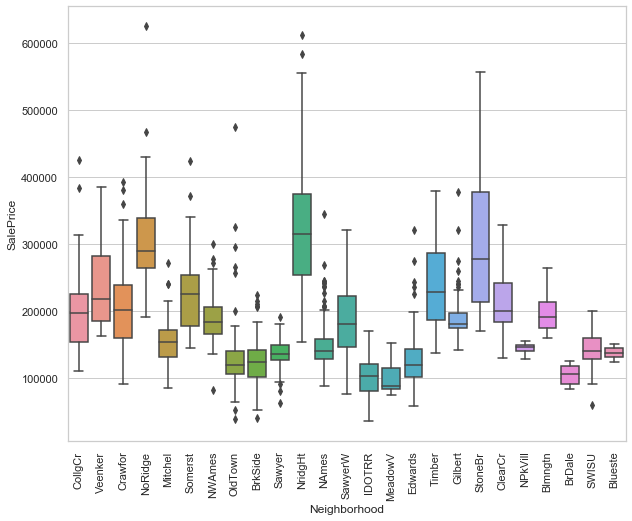

In [77]:
print(train.Neighborhood.unique())
sns.boxplot(data=train, x='Neighborhood', y='SalePrice')
plt.xticks(rotation=90)

In [78]:
neighborhood_map = {"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1
                    , "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, "Blueste" : 1
                    , "SWISU" : 2, "NAmes" : 2, "NPkVill" : 2, "Mitchel" : 2
                    , "SawyerW" : 2, "Gilbert" : 2, "NWAmes" : 2, "Blmngtn" : 2
                    , "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3
                    , "Somerst" : 3, "Timber" : 3, "StoneBr" : 4, "NoRidge" : 4
                    , "NridgHt" : 4}

alldata['NeighborhoodBin'] = alldata2['Neighborhood'].map(neighborhood_map)
alldata.loc[alldata2.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
alldata["Neighborhood_Good"].fillna(0, inplace=True)

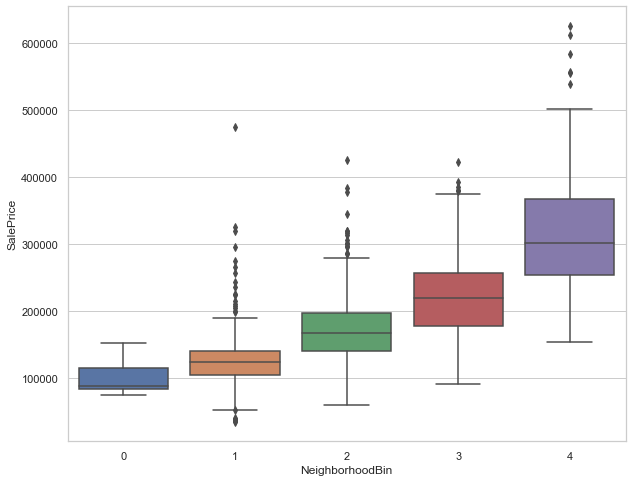

In [152]:
sns.boxplot(data=alldata, x='NeighborhoodBin', y='SalePrice')

エリアを住宅価格によって分けた。

特に良い立地条件のものにはラベルを振った。

In [79]:
train_new = alldata[alldata['SalePrice'].notnull()]
test_new = alldata[alldata['SalePrice'].isnull()]

print("Train", train_new.shape)
print ('----------------')
print("Test", test_new.shape)

Train (1456, 126)
----------------
Test (1459, 126)


In [81]:
alldata.to_csv('alldata.csv')

特徴量エンジニアリング終了

参考にしたノートブックではこの後にone-hot-encodingや、説明変数の分布の調整などが行われていたが、lightgbmならいらないという判断。参考にしたノートブックではxgboostとlasso回帰でモデルを作っていたため、このような操作が行われたと思われる。

## モデリング（準備）

In [139]:
data = import_data('../house price/alldata.csv')

Memory usage of dataframe is 2.82 MB
Memory usage after optimization is: 0.47 MB
Decreased by 83.3%


In [140]:
data = data.iloc[:,2:]
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SimplKitchenQual,SimplHeatingQC,SimplBsmtFinType1,SimplBsmtFinType2,SimplBsmtCond,SimplBsmtQual,SimplExterCond,SimplExterQual,NeighborhoodBin,Neighborhood_Good
0,60,3,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,2,2,2,1,1,2,1,2,2,0.0
1,20,3,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,1,2,2,1,1,2,1,1,3,0.0
2,60,3,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,2,2,2,1,1,2,1,2,2,0.0
3,70,3,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2,2,2,1,2,1,1,1,3,1.0
4,60,3,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,2,2,2,1,1,2,1,2,4,1.0


In [141]:
train = data[:len(train_new)]
test = data[len(train_new):]

In [142]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [143]:
data['SalePrice'] = np.log(data['SalePrice'])
data['SalePrice']

0       12.247694
1       12.109011
2       12.317166
3       11.849398
4       12.429216
          ...    
2910          NaN
2911          NaN
2912          NaN
2913          NaN
2914          NaN
Name: SalePrice, Length: 2915, dtype: float32

In [144]:
categorical_cols = list(data.select_dtypes(include=['category']).columns)
print(categorical_cols)

['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleCondition']


In [145]:
from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [146]:
train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})

In [147]:
train.shape, test.shape

((1456, 125), (1459, 125))

In [148]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [149]:
np.array(data.columns)

array(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDriv

In [153]:
categorical_cols = ['Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition',
       'IsRegularLotShape', 'IsLandLevel',
       'IsLandSlopeGentle', 'IsElectricalSBrkr', 'IsGarageDetached',
       'IsPavedDrive', 'HasShed', 'Remodeled',
       'VeryNewHouse', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
       'HasOpenPorch', 'HasEnclosedPorch', 'Has3SsnPorch',
       'HasScreenPorch', 'HighSeason', 'NewerDwelling',
       'SaleCondition_PriceDown', 'BoughtOffPlan', 'BadHeating',
       'TimeSinceSold', 'SeasonSold', 'NeighborhoodBin']

# ここ手動でやる以外に方法ないのか

## モデリング（lightgbm）

In [156]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 24,
    'max_depth': 6,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.267442	valid_1's rmse: 0.262048
[20]	training's rmse: 0.189954	valid_1's rmse: 0.191865
[30]	training's rmse: 0.14344	valid_1's rmse: 0.153298
[40]	training's rmse: 0.11622	valid_1's rmse: 0.133526
[50]	training's rmse: 0.100007	valid_1's rmse: 0.125285
[60]	training's rmse: 0.0899822	valid_1's rmse: 0.120741
[70]	training's rmse: 0.082691	valid_1's rmse: 0.117632
[80]	training's rmse: 0.0783009	valid_1's rmse: 0.116162
[90]	training's rmse: 0.0745355	valid_1's rmse: 0.115152
[100]	training's rmse: 0.071972	valid_1's rmse: 0.114405
[110]	training's rmse: 0.0694993	valid_1's rmse: 0.113921
[120]	training's rmse: 0.0670171	valid_1's rmse: 0.113693
[130]	training's rmse: 0.0651252	valid_1's rmse: 0.113636
[140]	training's rmse: 0.0632454	valid_1's rmse: 0.1133
[150]	training's rmse: 0.0610441	valid_1's rmse: 0.113305
[160]	training's rmse: 0.0590931	valid_1's rmse: 0.113178
Early stopping, best iteration 

In [157]:
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

CV: 0.12142352647305427


In [166]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)
# 0.12882

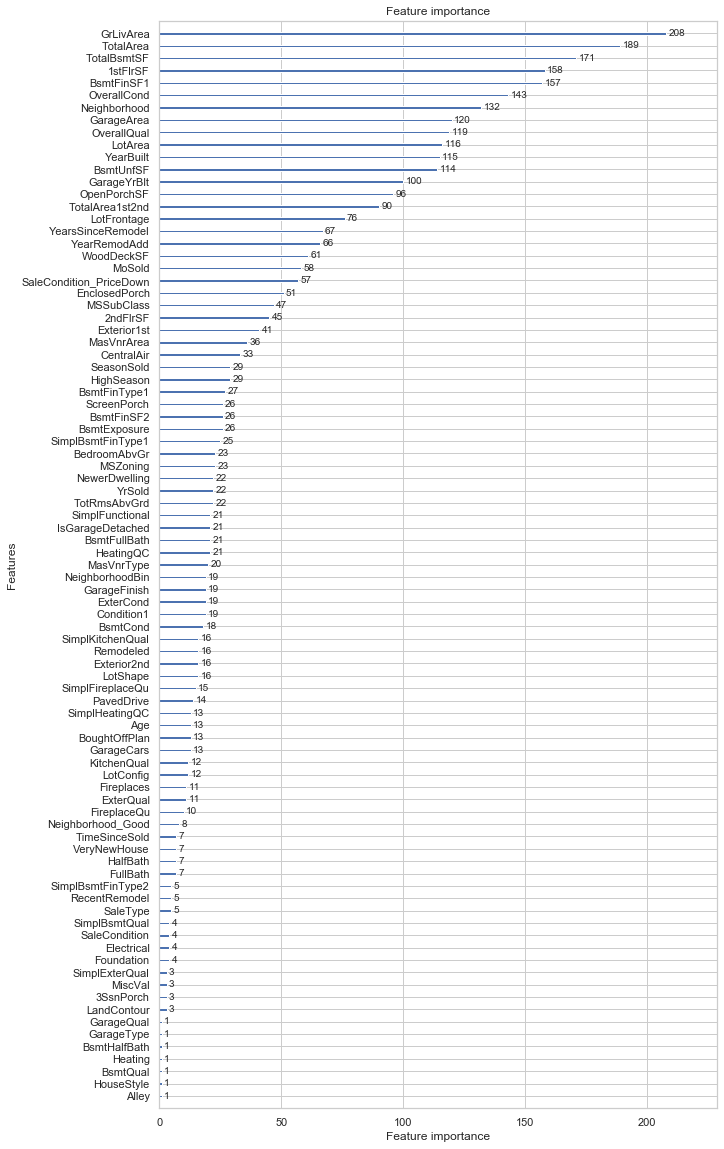

In [176]:
lgb.plot_importance(model, figsize=(10,20))